# Create report at extent-level (tile, basin, etc)
#### performs masking LC to create mask applied before for zonal stats of AGB

In [13]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
    
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer
import contextily as ctx

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
print("Importing packages complete.")
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Importing packages complete.


# Get the dictionary created from the building of the extent-level stack
extent_stack.ipynb

In [3]:
BASIN_COG_DICT = {
    'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_2485_cog.tif',
     'biomass_cog_fn':  '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_2485_cog.tif',
     'standage_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/standage_2485_cog.tif',
     'extent_gdf_fn':   '/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_3457_borealtiles.gpkg',
     'tcc2020_cog_fn':  '/projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_2485_cog.tif',
     'tccslope_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_2485_cog.tif',
     'tccpvalue_cog_fn':'/projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_2485_cog.tif'
}

### Replace the tile or basin ID in the current dict with any already run

In [101]:
TILE_NUM_LIST = [2139, 3358, 3204, 3203, 2832, 3265, 2485]
TILE_NUM = TILE_NUM_LIST[0]
FOCAL_EXTENT_ID = TILE_NUM
basin_area_ha = gpd.read_file(BASIN_COG_DICT['extent_gdf_fn']).area.to_list()[0] / 1e4

for key, value in BASIN_COG_DICT.items():
    BASIN_COG_DICT[key] = value.replace(value.split('_')[-2], str(FOCAL_EXTENT_ID))
    #print(value.split('_')[-2])
BASIN_COG_DICT

{'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_2139_cog.tif',
 'biomass_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_2139_cog.tif',
 'standage_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/standage_2139_cog.tif',
 'extent_gdf_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_2139_borealtiles.gpkg',
 'tcc2020_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_2139_cog.tif',
 'tccslope_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_2139_cog.tif',
 'tccpvalue_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_2139_cog.tif'}

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

In [102]:
os.path.basename(BASIN_COG_DICT['extent_gdf_fn'])

'extent_2139_borealtiles.gpkg'

Feature ID: 2139
Plot...
Get area of basin...
Area (ha.) of feature 2139:		810000.0
Plot...


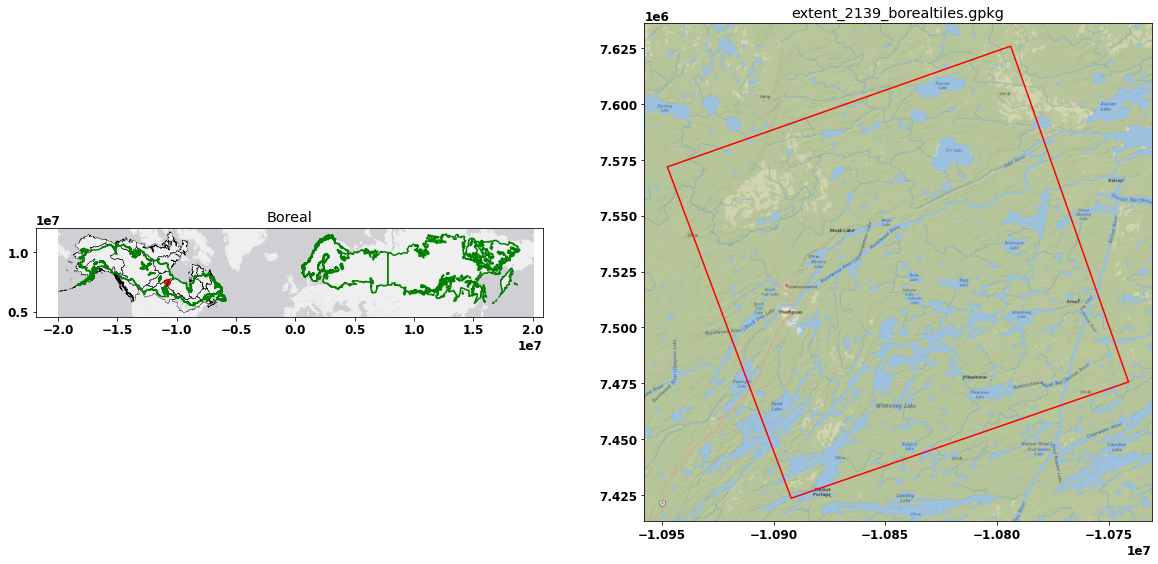

In [103]:
SHOW_FULL_EXTENT = False

print(f'Feature ID: {TILE_NUM}')

print('Plot...')
f, (ax1, ax2) = plt.subplots(figsize=(20, 25), ncols=2, nrows=1)
ax1.set_title(f"Boreal")
ax2.set_title(os.path.basename(BASIN_COG_DICT['extent_gdf_fn']))

xmin, xmax, ymin, ymax = [-180, 180, 40, 80]

# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Get the basins
hybas_border = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev03_vc1.gpkg', bbox=(xmin, ymin, xmax, ymax))
hybas_border[hybas_border.intersects(SUB_DOMAIN_selection_geometry)].to_crs(3857).boundary.plot(linewidth=0.25, color='black', ax=ax1)

# Get extent gdf
EXTENT_gdf = gpd.read_file(BASIN_COG_DICT['extent_gdf_fn'])
EXTENT_gdf.to_crs(3857).boundary.plot(color='red', linewidth=1, ax=ax1)
    
print('Get area of basin...')
basin_area_ha = EXTENT_gdf.area.to_list()[0] / 1e4
print(f"Area (ha.) of feature {TILE_NUM}:\t\t{round(basin_area_ha,2)}")

print('Plot...')
EXTENT_gdf.centroid.to_crs(3857).plot(color='red', ax=ax1)
EXTENT_gdf.to_crs(3857).boundary.plot(color='red', ax=ax2)
boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).boundary.plot(color='green', marker = '---', ax=ax1)
ctx.add_basemap(ax1,  source="http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}")
ctx.add_basemap(ax2,  source="https://services.arcgisonline.com/arcgis/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}")

# Create extent report
### Open clipped Worldcover COG and corresponding AGB, loop over LC classes, masking, summing, etc


Area (ha.) of extent 2139:		810000.0000000335

lc_arr shape: (3000, 3000)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 3000, 'height': 3000, 'count': 2, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 3878521.9999999953,
       0.0, -30.0, 4563304.000000009), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
agb nodata value: None
agb_arr shape: (3000, 3000)

0 Trees 10
	# land cov pi

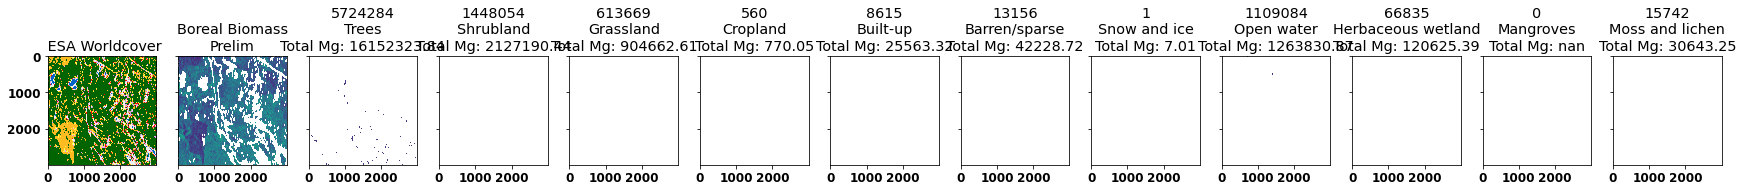

In [104]:
## %%time

# The area in hectares of a 30m pixel
area_pix_ha = 0.09

# The land cover values in which you want to summarize AGB
values_worldcover = [10,20,30,40,\
                     50,\
                     60,70,80,90,95,100] #'Trees', 'Shrubland', 'Grassland','Cropland', 'Barren / sparse vegetation', 'Herbaceous wetland','Moss and lichen'

fig, axes = plt.subplots(nrows=1, ncols=len(values_worldcover)+2, figsize=(30,10), sharex=True, sharey=True)

# Read back in the topo_stack_cog_fn and plot

with rasterio.open(BASIN_COG_DICT['landcover_cog_fn']) as dataset:
    
    lc_meta = dataset.profile
    
    print(f"\nArea (ha.) of extent {TILE_NUM}:\t\t{basin_area_ha}")
    
    lc_arr = dataset.read(1)
    print(f"\nlc_arr shape: {lc_arr.shape}")
    
    # NoData value is 0; mask this
    lc_arr = np.ma.masked_where( lc_arr == 0, lc_arr)
    
    # Plotting
    names_worldcover = [ 'Trees', 'Shrubland', 'Grassland','Cropland',\
                        'Built-up',
                        'Barren/sparse','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = [ "#006400","#ffbb22","#ffff4c","#f096ff",\
                       "#fa0000",\
                       "#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    #cols_mask = ["white", "red"]
    #values_mask = [0,1]

    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))

    #cmap_masked = ListedColormap(cols_mask)
    #norm_masked= BoundaryNorm(values_mask, len(cols_mask))
    
    axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
    axes[0].set_title(f" ESA Worldcover")
    
    # Find sum of AGB per LC class
    # multiply by AGB values and sum
    with rasterio.open(BASIN_COG_DICT['biomass_cog_fn']) as dataset_agb:
        
        print(dataset_agb.profile)
        
        agb_arr = dataset_agb.read(1)
        print(f"agb nodata value: {dataset_agb.nodata}")
        
        #agb_arr = np.ma.masked_where( (lc_arr==0) | (agb_arr<0), agb_arr)
        agb_arr = np.ma.masked_where(  (agb_arr<0), agb_arr)
        total_mg_all = np.nansum(agb_arr)
        
        print(f"agb_arr shape: {agb_arr.shape}\n")
        axes[1].imshow(agb_arr, clim=(0,75))
        axes[1].set_title(f"Boreal Biomass\nPrelim")
    
        for i, LC_VALUE in enumerate(values_worldcover):
        #for i, LC_VALUE in enumerate([v for v in LC_VAL_LIST if v in values_worldcover ]):

            LC_NAME = names_worldcover[i]
            print(i, LC_NAME, LC_VALUE)

            # For LC value of interest
            #lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr != LC_VALUE) , agb_arr)
            lc_agb_arr = np.ma.masked_where( (lc_arr != LC_VALUE) , agb_arr)
            
            num_lc_pixels_in_mask = lc_agb_arr[~np.isnan(lc_agb_arr)].count() 
            num_lc_pixels_in_mask = lc_agb_arr.count()
            total_lc_area_ha = num_lc_pixels_in_mask * area_pix_ha
            
            print(f"\t# land cov pixels in class:\t\t\t{num_lc_pixels_in_mask}")
            print(f"\t# Total area (ha.) in class:\t\t\t{total_lc_area_ha} ({round(100 * total_lc_area_ha / basin_area_ha,2)}% of extent)")
            
            total_mg_lc = np.nan
            
            if False and LC_VALUE == 40:
                list_of_vals = lc_agb_arr[lc_agb_arr.mask == False].tolist()
                print(list_of_vals)
                #print(f"\t\t{(sum(list_of_vals) / num_lc_pixels_in_mask) * area_pix_ha}")
                
            if LC_VALUE == 10:
                trees_lc_agb_arr = lc_agb_arr
            
            if num_lc_pixels_in_mask > 0:
                
                print(f"\tMg/ha (min,mean,med,max):\t\t\t\t{round(np.nanmin(lc_agb_arr),2)}, {round(np.nanmean(lc_agb_arr),2)}, {round(np.ma.median(lc_agb_arr),2)} , {round(np.nanmax(lc_agb_arr),2)}")

                # ***To get error bars on total (Mg), need to have mean AGB raster and sd AGB raster, and use them to sample a normal distribution of AGB values per pixel, n=100 times per pixel?
                # Then get all the totals from the n layers, and get the mean total and the sd of the total
                #total_mg_lc = (lc_agb_arr.sum() / num_lc_pixels_in_mask) * area_pix_ha
                total_mg_lc = np.nansum(lc_agb_arr * area_pix_ha)
                print(f"\tTotal AGB (Mg) in class:\t\t\t{round( total_mg_lc, 2)} ({round(100 * total_mg_lc / total_mg_all,2)}% of extent biomass)")
            
            # To plot with a legend: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
            axes[i+2].imshow(lc_agb_arr, clim=(-100,700))
            axes[i+2].set_title(f"{num_lc_pixels_in_mask}\n{LC_NAME}\nTotal Mg: {round(total_mg_lc,2)}")
            
            #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
            #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [105]:
!pip install -U matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar
def add_colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label)
    plt.sca(last_axes)
    return cbar



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Map biomass for Tree extents
The extent of 'trees' in the ESA Worldcover v1 2020 land cover dataset provides an independent mask to sum biomass for each polygon

Extent:		2139
Total ha.:		709721.73
Mean Mg/ha:		27.34
Total Pg.:		0.0194
Mean Mg/ha in trees:	31.37
Total Pg. in trees:	0.0162


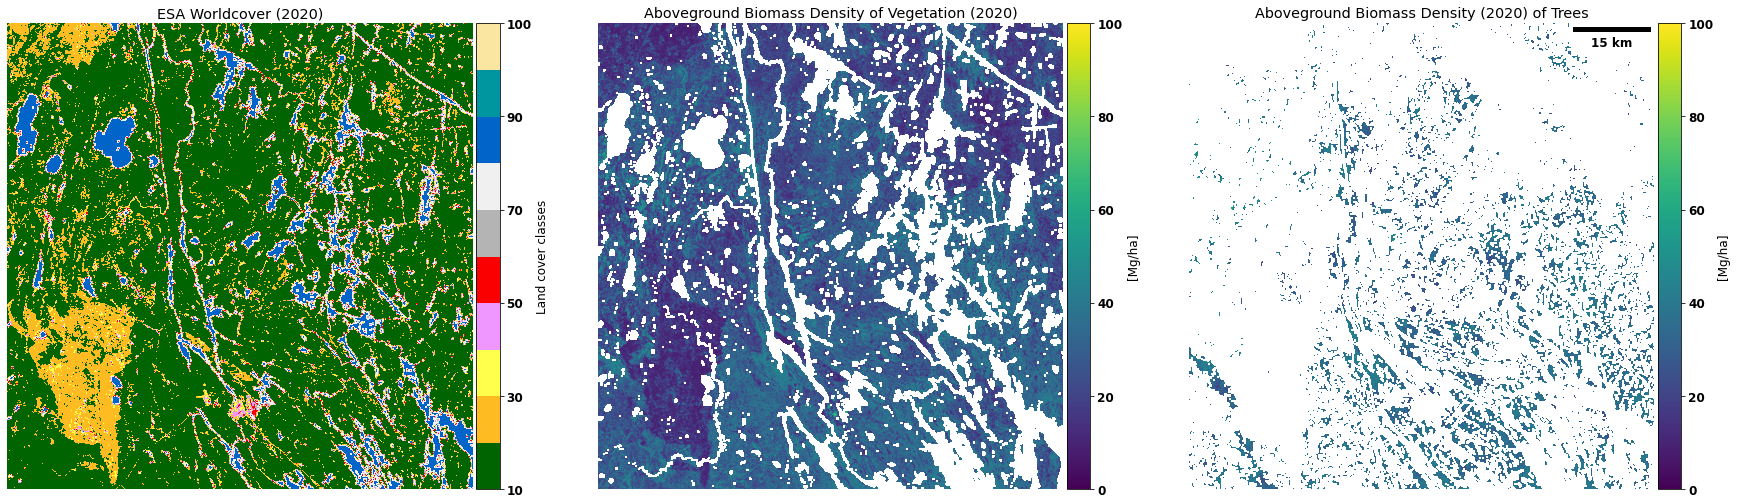

In [106]:
LC_VAL = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

##########
# AGB arrays
# With a water mask
agb_arr_masked = np.ma.masked_where( (lc_arr == 0  ) | (lc_arr == 80) , agb_arr)

##########
# Without a water mask
#agb_arr_masked = np.ma.masked_where( (lc_arr == 0  )  ,agb_arr)

##########
# AGB density of ESA Worldcover v1 2020 trees 
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != LC_VAL  ), agb_arr_masked)

print(f"Extent:\t\t{TILE_NUM}")
print(f"Total ha.:\t\t{(agb_arr_masked[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }")
print(f"Mean Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }")
print(f"Mean Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")

# Plots

# Showing only trees LC
#m2 = axes[1].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
# Showing all LC classes
m1 = axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m1, 'Land cover classes')
axes[0].set_title('ESA Worldcover (2020)')
axes[0].axis('off')

m2 = axes[1].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m2, '[Mg/ha]')
m2 = axes[1].set_title('Aboveground Biomass Density of Vegetation (2020)')
axes[1].axis('off')

# Show AGB for tree
m3 = axes[2].imshow(agb_arr_masked_trees, clim=(0,100), cmap='viridis')
add_colorbar(m3, '[Mg/ha]')
m3 = axes[2].set_title('Aboveground Biomass Density (2020) of Trees')
axes[2].axis('off')

if False:
    # Convert AGB density to total
    m4 = axes[3].imshow(agb_arr_masked_trees* area_pix_ha, clim=(0,10), cmap='plasma')
    add_colorbar(m3, '[Mg]')
    m4 = axes[3].set_title('Aboveground Biomass (2020) of Trees')
    axes[3].axis('off')

# Carbon accumulation

In [107]:
standage_arr = rasterio.open(BASIN_COG_DICT['standage_cog_fn']).read(1)
tccslope_arr = rasterio.open(BASIN_COG_DICT['tccslope_cog_fn']).read(1)
tcc2020_arr = rasterio.open(BASIN_COG_DICT['tcc2020_cog_fn']).read(1)

Extent:		2139

Total ha.:		514874.07

Mean AGB Mg/ha in all classes (even water):		27.15
Total AGB Pg. in all classes (even water):	0.0207
Water AGB adds additional 0.001264 Pg. to the Total land AGB, an increase of 6.513 %

Mean AGB Mg/ha:		27.34
Total AGB Pg.:		0.0194

Mean AGB Mg/ha in trees:	31.37
Total AGB Pg. in trees:	0.0162
Tree AGB is 0.8324 of Total land AGB

Mean Net C accumulation in trees:	0.37 MgC/ha/yr
Total Pg. C in trees:	0.0002 Pg
Mean Net C accumulation in all classes:	0.37 MgC/ha/yr
Total Pg. C in all classes:	0.0002 Pg
Tree C is 0.7937 of Total land aboveground C

This C proportion doesnt match the AGB proportion due to pixel with stand age = 0
---This doesnt make sense yet --> Adjusted Tree C is 0.5714 of Total land aboveground C



(-0.5, 2999.5, 2999.5, -0.5)

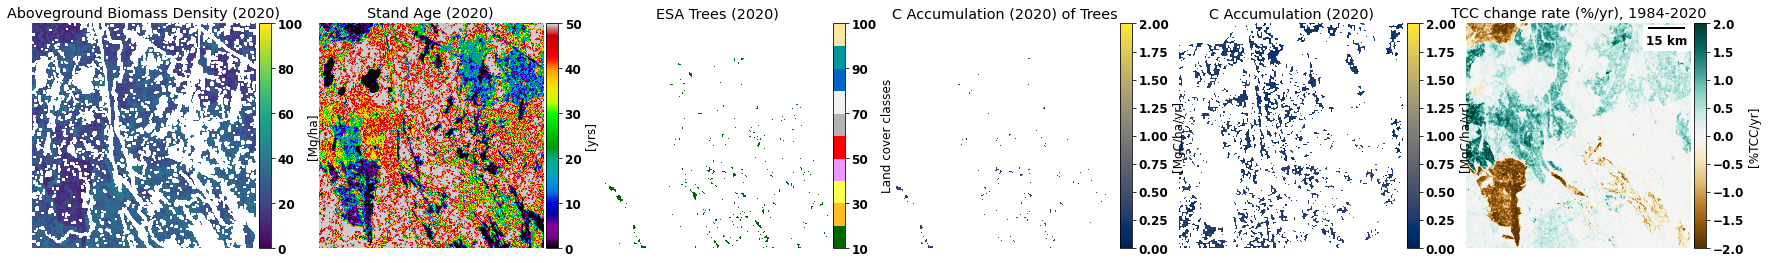

In [108]:
val_lc_nodata, val_lc_trees, val_lc_water = [0, 10, 80]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

#
# Stand age masked with its nodata
#
standage_arr_masked = np.ma.masked_where( (standage_arr == ndv_standage ), standage_arr) # <-- note, leaving in age = 0 here, technically not 'stands'? or just 'recently disturbed stands' - how to get C accumulation when denom is 0?
standage_arr_masked_adj = np.ma.where(standage_arr_masked == 0, 0.5, standage_arr_masked) # <-- instead of age = 0, age = 0.5
standage_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked)
standage_arr_masked_adj_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked_adj)

#
# LC masked with its nodata and water
#
lc_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  ) | (lc_arr == val_lc_water) , lc_arr)
lc_arr_trees = np.ma.masked_where( (lc_arr != val_lc_trees  )  , lc_arr_masked)

# TCC variables masked with its nodata
tccslope_arr = np.ma.masked_where( (tccslope_arr == ndv_tccslope ) , tccslope_arr)
tcc2020_arr = np.ma.masked_where( (tcc2020_arr == ndv_tcc ) , tcc2020_arr)

# AGB masked with lc nodata
agb_water_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  )  , agb_arr)
# ..and additionally with water
agb_arr_masked = np.ma.masked_where(  (lc_arr == val_lc_water) , agb_water_arr_masked)
# ..and additionally with ESA Worldover trees
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), agb_arr_masked)

# Carbon accumulation per year (Annual net C accumulation rate)
ratio_c_agb = 0.5
netc_accum_arr = (agb_arr_masked * ratio_c_agb) / standage_arr_masked
netc_accum_arr_adj= (agb_arr_masked * ratio_c_agb) / standage_arr_masked_adj
netc_accum_arr_trees = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked
netc_accum_arr_trees_adj = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked_adj


# Get the total water AGB
land_water_agb_total = (np.nansum(agb_water_arr_masked)/1e9 * area_pix_ha)
land_agb_total = (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)
water_agb_total = land_water_agb_total - land_agb_total

print(f"Extent:\t\t{TILE_NUM}\n")
print(f"Total ha.:\t\t{(agb_arr_masked_trees[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }\n")

print(f"Mean AGB Mg/ha in all classes (even water):\t\t{ round(np.nanmean(agb_arr),2) }")
print(f"Total AGB Pg. in all classes (even water):\t{round(np.nansum(agb_arr)/1e9 * area_pix_ha, 4) }")
print(f"Water AGB adds additional { round(water_agb_total, 6)} Pg. to the Total land AGB, an increase of { round(water_agb_total / land_agb_total * 100 , 3) } %\n")

# Land AGB
print(f"Mean AGB Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total AGB Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }\n")

# Tree AGB
print(f"Mean AGB Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total AGB Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")
print(f"Tree AGB is {round(  (np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha) / (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)  , 4) } of Total land AGB\n")

# Carbon accumulation
print(f"Mean Net C accumulation in trees:\t{ round(np.nanmean( netc_accum_arr_trees),2) } MgC/ha/yr")
print(f"Total Pg. C in trees:\t{round(np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha, 4) } Pg")
print(f"Mean Net C accumulation in all classes:\t{ round(np.nanmean( netc_accum_arr),2) } MgC/ha/yr")
print(f"Total Pg. C in all classes:\t{round(np.nansum(netc_accum_arr)/1e9 * area_pix_ha, 4) } Pg")
print(f"Tree C is {round(  (np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")
print("This C proportion doesnt match the AGB proportion due to pixel with stand age = 0")
print(f"---This doesnt make sense yet --> Adjusted Tree C is {round(  (np.nansum(netc_accum_arr_trees_adj)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr_adj)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")

# Plots
# Biomass
m1 = axes[0].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m1, '[Mg/ha]')
m1 = axes[0].set_title('Aboveground Biomass Density (2020)')
axes[0].axis('off')

# Age
m2 = axes[1].imshow(standage_arr_masked, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[1].set_title('Stand Age (2020)')
axes[1].axis('off')

# Showing trees instead of all LC classes
m3 = axes[2].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m3, 'Land cover classes')
axes[2].set_title('ESA Trees (2020)')
axes[2].axis('off')

# Carbon accumulation in trees
m4 = axes[3].imshow(netc_accum_arr_trees, clim=(0,2), cmap='cividis')
add_colorbar(m4, '[MgC/ha/yr]')
m4 = axes[3].set_title('C Accumulation (2020) of Trees')
axes[3].axis('off')

# Carbon accumulation in all classes
m5 = axes[4].imshow(netc_accum_arr, clim=(0,2), cmap='cividis')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[4].set_title('C Accumulation (2020)')
axes[4].axis('off')

# TCC trend 1984-2020
m6 = axes[5].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[5].set_title('TCC change rate (%/yr), 1984-2020')
axes[5].axis('off')

#### Check trees and C accum with larger maps

(-0.5, 2999.5, 2999.5, -0.5)

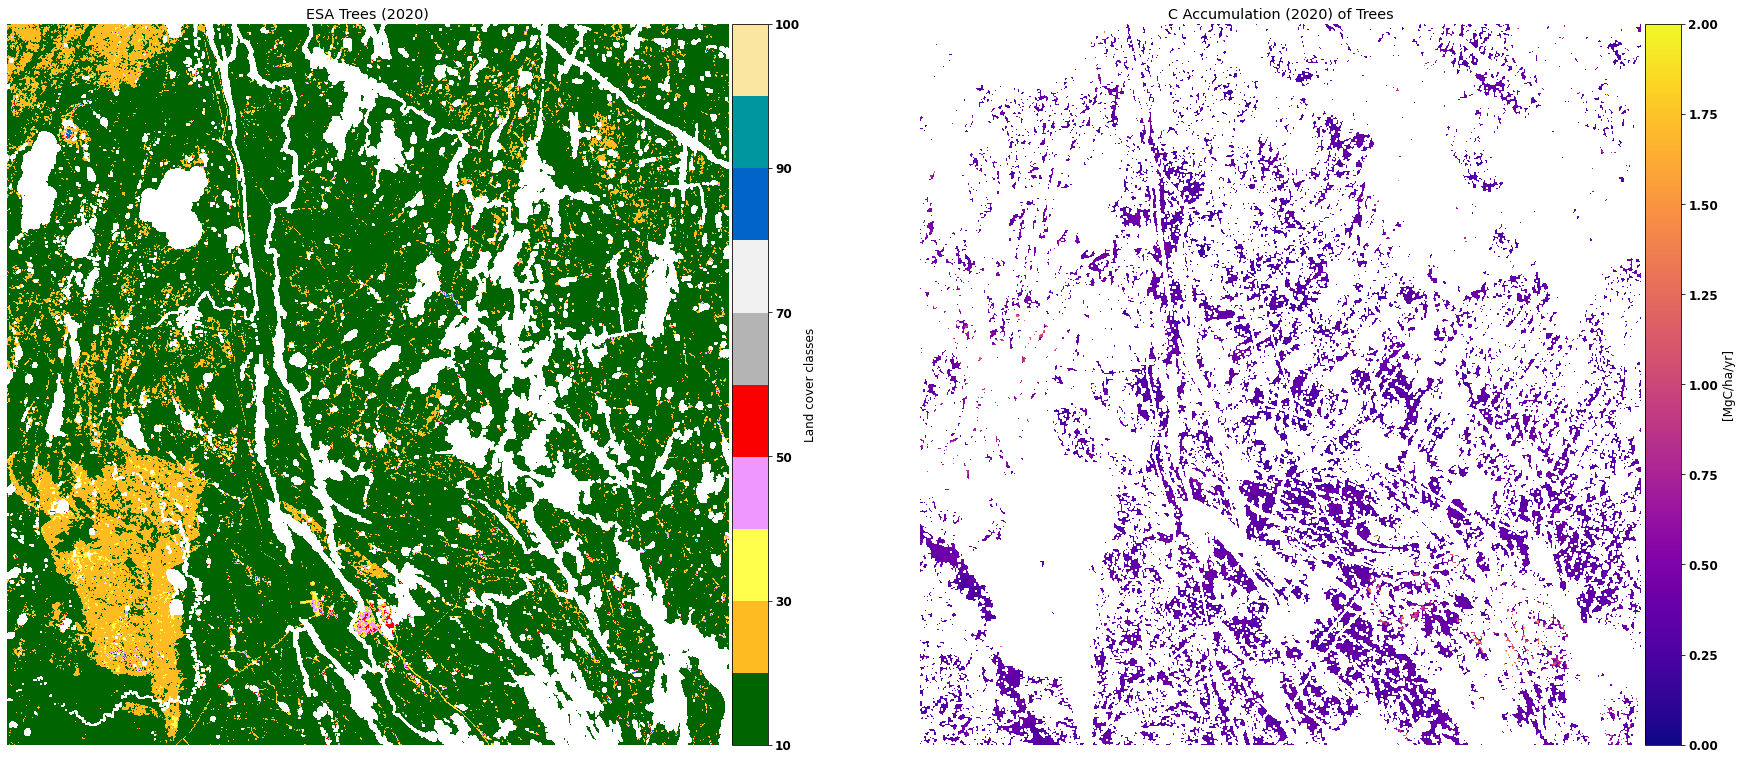

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,30), sharex=True, sharey=True)
# Showing trees instead of all LC classes
m3 = axes[0].imshow(lc_arr_masked, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m3, 'Land cover classes')
axes[0].set_title('ESA Trees (2020)')
axes[0].axis('off')

# Carbon accumulation in trees
m4 = axes[1].imshow(netc_accum_arr_trees, clim=(0,2), cmap='plasma')
add_colorbar(m4, '[MgC/ha/yr]')
m4 = axes[1].set_title('C Accumulation (2020) of Trees')
axes[1].axis('off')

#### Check stand age in trees vs all stand age

### Stand age, carbon accumulation, and tree cover rate change maps

(-0.5, 2999.5, 2999.5, -0.5)

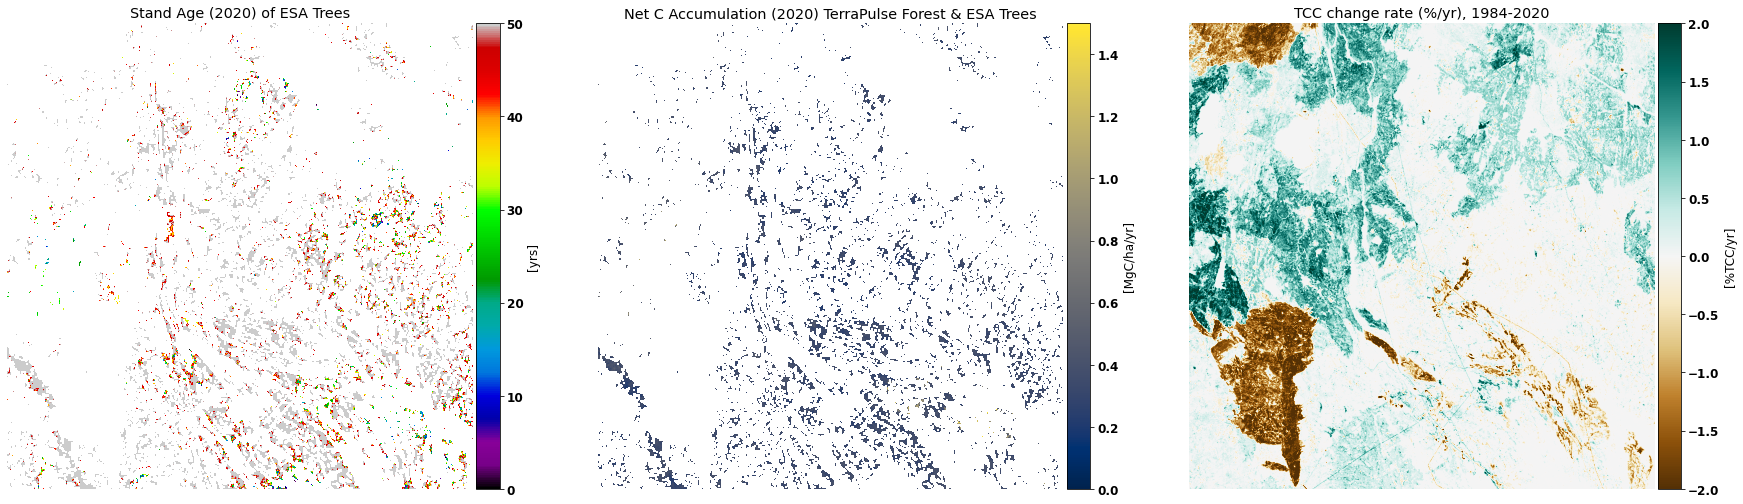

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Age
m2 = axes[0].imshow(standage_arr_masked_trees, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[0].set_title('Stand Age (2020) of ESA Trees')
axes[0].axis('off')

# Carbon accumulation
m5 = axes[1].imshow(netc_accum_arr_trees, clim=(0,1.5), cmap='cividis')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[1].set_title('Net C Accumulation (2020) TerraPulse Forest & ESA Trees')
axes[1].axis('off')

# TCC trend 1984-2020
m6 = axes[2].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[2].set_title('TCC change rate (%/yr), 1984-2020')
axes[2].axis('off')

### Binned scatterplots

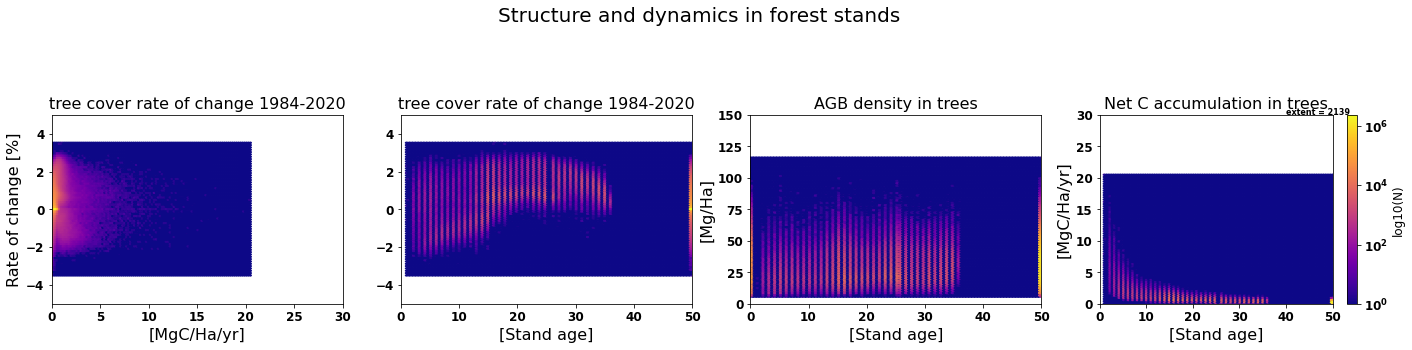

In [119]:
# Mask TCC trends with 
tccslope_masked = np.ma.masked_where(netc_accum_arr_trees.mask, tccslope_arr)

lims_c_accum = [0,30]
lims_stand_age = [0,50]
lims_tcc_change = [-5, 5]

#Declaring the figure, and hiding the ticks' labels
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,5))
st = fig.suptitle("Structure and dynamics in forest stands", fontsize=20,  horizontalalignment='center')

## Actually Plotting the data
# Binned scatterplots
ax1.hexbin(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
ax2.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
ax3.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(agb_arr_masked_trees), gridsize=100, bins='log', cmap='plasma')
hb=ax4.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees), gridsize=100, bins='log', cmap='plasma')


# Scatterplots
#ax1.scatter(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax2.scatter(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax3.scatter(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees),  s=0.1, c='black', alpha=0.01)

#Making the graph pretty and informative!
ax1.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax1.set_ylabel("Rate of change [%]", fontsize=16)
ax1.set_xlabel("[MgC/Ha/yr]", fontsize=16)
ax1.set_ylim(lims_tcc_change)

ax2.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax2.set_xlabel("[Stand age]", fontsize=16)
ax2.set_ylim(lims_tcc_change)

ax3.set_title("AGB density in trees", fontsize=16)
ax3.set_ylabel("[Mg/Ha]", fontsize=16)
ax3.set_ylim((0,150))
ax3.set_xlabel("[Stand age]", fontsize=16)

ax4.set_title("Net C accumulation in trees", fontsize=16)
ax4.set_ylabel("[MgC/Ha/yr]", fontsize=16)
ax4.set_ylim(lims_c_accum)
ax4.set_xlabel("[Stand age]", fontsize=16)
ax4.text(0.80,
         1.0, 
         f"extent = {TILE_NUM}",
         transform=plt.gca().transAxes,
         color = "black",
         fontsize=8
        )
cb = fig.colorbar(hb, ax=ax4)
cb.set_label('log10(N)')

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.65)

ax1.set_xlim(lims_c_accum)
ax2.set_xlim(lims_stand_age)
ax3.set_xlim(lims_stand_age)
ax4.set_xlim(lims_stand_age)
plt.show()

# Try this next but need to remove nans from each array: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

## Questions to answer
For trees in stands =< 36 yrs, 
1. what is the total AGB (Pg) and what is C?  
2. what is the percentage of overall C?

## Write a new stack
Band 1: ESA WorldCover  
Band 2: ABoVE AGB for ESA veg mask  
Band 3: ABoVE AGB for ESA tree mask  
Band 4: ABoVE Net C accumulation in trees with stand age (TP forest stand age x ESA tree mask ) 
 - not doing this stack correctly - fill value and nodata need to be looked at


In [ ]:
# Stack
# move axis of the stack so bands is first
# LC array (int) mask filled with 0 .... AGB arrays (floats) filled with nan
#analysis_stack = np.stack([lc_arr.filled(0) , agb_arr_masked.filled(-9999) , agb_arr_masked_trees.filled(-9999) ])
analysis_stack = np.stack([lc_arr, agb_arr_masked , agb_arr_masked_trees,  ])
analysis_stack_names = ["lc", "agb_veg", "agb_tree", "stand_age", ]

# Copy input agb metadata
out_meta = dataset_agb.profile
out_meta

# write COG to disk
write_cog(
            analysis_stack, 
            os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif", 
            out_meta['crs'], 
            out_meta['transform'], 
            analysis_stack_names, 
            out_crs=out_meta['crs'],
    input_nodata_value= -9999
             )

In [ ]:
src = rasterio.open(os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif")
print(src.profile['nodata'])
arr = src.read(2)
#arr = np.ma.masked_where((arr <0) , arr)
show(arr)

## Read rasters from stack

In [40]:
def examine_raster(r_fn, ndv, band=1):
    with rasterio.open(r_fn) as ds:
        
        print(ds.nodata)

        arr = ds.read(band)

        arr = np.ma.masked_where(arr == ndv, arr)
        show_hist(arr)

In [41]:
ndv_standage = 255
ndv_tccslope = -9999
ndv_tcc = 255
standage_arr = rasterio.open(BASIN_COG_DICT['standage_cog_fn']).read(1)
tccslope_arr = rasterio.open(BASIN_COG_DICT['tccslope_cog_fn']).read(1)
tcc2020_arr = rasterio.open(BASIN_COG_DICT['tcc2020_cog_fn']).read(1)

In [42]:
#examine_raster(os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif", -9999., band=2)

In [ ]:
examine_raster(BASIN_COG_DICT['tcc2020_cog_fn'], ndv_tcc)

In [ ]:
examine_raster(BASIN_COG_DICT['standage_cog_fn'], ndv_standage)

In [ ]:
examine_raster(BASIN_COG_DICT['tccslope_cog_fn'], ndv_tccslope)

# Stack the masked data and build a dataframe
https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

In [ ]:
%matplotlib inline

#Return a common mask for a set of input ma
def common_mask(ma_list, apply=False):
    if type(ma_list) is not list:
        print("Input must be list of masked arrays")
        return None
    #Note: a.mask will return single False if all elements are False
    #np.ma.getmaskarray(a) will return full array of False
    #ma_list = [np.ma.array(a, mask=np.ma.getmaskarray(a), shrink=False) for a in ma_list]
    a = np.ma.array(ma_list, shrink=False)
    #Check array dimensions
    #Check dtype = bool
    #Masked values are listed as true, so want to return any()
    #a+b+c - OR (any)
    mask = np.ma.getmaskarray(a).any(axis=0)
    #a*b*c - AND (all)
    #return a.all(axis=0)
    if apply:
        return [np.ma.array(b, mask=mask) for b in ma_list] 
    else:
        return mask

#
# --UPDATE TO A COMMON MASK for the stack
#
arr_list = common_mask([lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr], apply=True)
#arr_list = [lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr]

print(arr_list[0].count())
stack = np.stack([arr[(netc_accum_arr>=0) & (tcc2020_arr < 255)].data.flatten() for arr in arr_list],axis=1)

# Common mask
#stack = common_mask(stack, apply=True)

# Build data frame
VARS_LIST = ['LC','Mg_ha', 'Age_yr','Mg_C_ha_yr','TCC_slope','TCC_2020']
stack_df = pd.DataFrame(stack, columns = VARS_LIST)

# Clean
stack_df['Age_yr'] = stack_df['Age_yr'].apply(int)
remap_dict = dict(zip(values_worldcover, names_worldcover))
stack_df['LC'] = stack_df['LC'].replace(remap_dict)
stack_df['LC'] = pd.Categorical(stack_df['LC'], categories=names_worldcover, ordered=True)
stack_df.info()

### Histogram of TCC rate of change, 1984-2020

In [ ]:
stack_df.head()
# -- get a summary here to check that invalid values are removed

This will kill the kernel

In [ ]:
if False:
    plotnine.options.figure_size = (5, 2)

    # Melt
    stack_df['pix_idx'] = stack_df.index

    stack_df_m = pd.melt(stack_df, id_vars=['pix_idx'], value_vars=VARS_LIST)

    median_tcc_val = stack_df.TCC_slope.median()                  
    print(f"Median TCC change rate, 1984-2020 (% TCC/yr):\t\t{median_tcc_val}")
    print(
        (
            ggplot(aes( x='value', fill='variable'), data=stack_df_m ) 
            + geom_histogram(binwidth=1)
            + geom_vline(xintercept=0, linetype = 'dashed')
            #+ scale_fill_brewer(palette='BrBG', type="diverging")
            #+ coord_cartesian(xlim=(-4,4))
            + facet_grid('variable~.')
            + theme_minimal()
        ) 
    )

# Summarize by land cover
summarize 
+ biomass density
+ carbon accumulation rate

by
+ land cover
+ age

In [ ]:
stack_df_smry = pd.DataFrame(
    stack_df.groupby(["LC","Age_yr"]).agg(
            {
            "Mg_ha": ["sum", "min", "max", "median", "skew", "std", "count"], # np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha
            "Mg_C_ha_yr": ["min", "max", "median", "skew", "std", "count"]#,
            #"Age_yr": ["min", "max", "median", "skew", "std", "count"]
              }
                        )
    
)
##stack_df_smry['LC'] = stack_df_smry.index
stack_df_smry.index = stack_df_smry.index.set_names(['LC', 'Age'])

stack_df_smry.reset_index(drop=False, inplace=True)

stack_df_smry.columns = [' '.join(col).strip() for col in stack_df_smry.columns.values]

# Convert sum to Pg, normalize sum by area of pixel
stack_df_smry['Total_Pg'] = stack_df_smry['Mg_ha sum']/1e9 * area_pix_ha

stack_df_smry.dropna()


In [ ]:
(
    ggplot(aes( x='Age_yr', fill='LC'), data=stack_df.dropna()[~stack_df['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='count')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Total Biomass per land cover class

In [ ]:
FILTER_LIST = ['Open water', 'Barren/sparse', 'Built-up']
KEEP_LIST = ['Trees']
(
    ggplot(aes(y='Total_Pg', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Carbon accumulation rate

In [ ]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
) 

## TCC change rate

In [ ]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
)

In [ ]:
p = ggplot(aes(x='Mg_C_ha_yr', fill='LC'), data=df)
p + geom_histogram(binwidth=1)